In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.patches as patches
import string
import matplotlib.cm as cm
from cmcrameri import cm as cr

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/double_keel_article/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest

In [2]:

# def plot_particles_of_a_layer_temperature_coded(axs, i, current_time, time, x_track, z_track, P, T, T_max, P_max, particle, markersize=4, linewidth=0.15, line_alpha=0.6, h_air=40.0e3,
#                                                 color_mid_T='xkcd:dark green', color_high_T_wedge='xkcd:bright purple', color_high_T_subducted='xkcd:orange',
#                                                 plot_steps=False):


def plot_particles_of_a_layer_temperature_coded(ax0, ax1, i, trackdataset, markersize=4, linewidth=0.15, line_alpha=0.6, h_air=40.0e3, plot_lower_crust_particles=True,
                                               color_wedge='xkcd:orange', #orogenic wedge rocks T<900 and P<2GPa
                                               color_mid_T='xkcd:teal', #subducted crustal rocks 400<T<900 and P>2GPa
                                               color_high_T_wedge='xkcd:raspberry', #orogenic wedge rocks T>900 and P<2GPa
                                               color_high_T_subducted='xkcd:dirty purple', #subducted crustal rocks T>900 and P>2GPa
                                               ):
    
    '''
    Plot the particles of a specific layer with temperature and pressure coding.

    Parameters:
    - ax0: axis for the spatial plot (x vs z).
    - ax1: axis for the P-T plot.
    - i: current time step index.
    - trackdataset: xarray dataset containing the tracked particle data.
    - markersize: size of the markers in the P-T plot.
    - linewidth: width of the lines in the P-T plot.
    - line_alpha: transparency of the lines in the P-T plot.
    - h_air: thickness of the air layer to adjust z-coordinates.
    - plot_lower_crust_particles: boolean to control whether to plot lower crust particles.
    - color_wedge: color for orogenic wedge rocks with 400<T<900 and P<2GPa.
    - color_mid_T: color for subducted crustal rocks with 400<T<900 and P>2GPa.
    - color_high_T_wedge: color for orogenic wedge rocks with T>900 and P<2GPa.
    - color_high_T_subducted: color for subducted crustal rocks with T>900 and P>2GPa.
    '''

    asthenosphere_code = 0
    lower_craton_code = 1
    upper_craton_code = 2
    mantle_lithosphere_code = 3
    lower_crust1_code = 4
    seed_code = 5
    lower_crust2_code = 6
    upper_crust_code = 7
    decolement_code = 8
    sediments_code = 9
    air_code = 10

    x_track = trackdataset.xtrack.values[::-1]
    z_track = trackdataset.ztrack.values[::-1]
    P = trackdataset.ptrack.values[::-1]
    T = trackdataset.ttrack.values[::-1]
    time = trackdataset.time.values[::-1]
    steps = trackdataset.step.values[::-1]

    n = int(trackdataset.ntracked.values)
    nTotal = np.size(x_track)
    steps = nTotal//n
    

    x_track = np.reshape(x_track,(steps,n))
    z_track = np.reshape(z_track,(steps,n))
    P = np.reshape(P,(steps,n))/1.0e3 #GPa
    T = np.reshape(T,(steps,n))
    T_maxs = np.max(T, axis=0) #get the maximum temperature for each particle to categorize by temperature
    P_maxs = np.max(P, axis=0) #get the maximum pressure for each particle to categorize by pressure

    particles_layers = trackdataset.particles_layers.values[::-1] #code of the tracked layers

    for particle, particle_layer, T_max, P_max in zip(range(n), particles_layers, T_maxs, P_maxs):
        
        if((plot_lower_crust_particles == True) & ((particle_layer == lower_crust1_code) | (particle_layer == lower_crust2_code))):
            
            if(T_max >= 400 and T_max < 900.0):
                if(P_max < 2.0):
                    color = color_wedge
                if(P_max >= 2.0):
                    color = color_mid_T
            if(T_max >= 900.0):
                if(P_max < 2.0):
                    color = color_high_T_wedge
                if(P_max >= 2.0):
                    color = color_high_T_subducted
            
            ax0.plot(x_track[i, particle]/1.0e3,
                            z_track[i, particle]/1.0e3+h_air/1.0e3,
                            marker='.',
                            markersize=1.5,#markersize-2,
                            color=color,
                            zorder=60)
            ax1.plot(T[i, particle], P[i, particle], '.', color=color, markersize=markersize)
            ax1.plot(T[:i, particle], P[:i, particle], '-', color=color, linewidth=linewidth, alpha=line_alpha, zorder=60)


def plot_PT_fields(ax, vertices, x_text, y_text, label, color, fsize_text=6, linewidth=0.01, alpha=0.3):
    """
    Plot the P-T fields as a polygon on the given axis.
    
    Parameters:
    - ax: The axis to plot on.
    - vertices: The vertices of the polygon.
    - color: The color of the polygon.
    - label: The label for the polygon.
    """
    polygon = patches.Polygon(
        vertices,
        closed=True,
        facecolor=color,
        alpha=alpha,
        edgecolor=color,
        linewidth=linewidth
        )
    ax.add_patch(polygon)

    ax.text(
            x_text,
            y_text,
            label,   # texto
            fontsize=fsize_text,
            color=color,
            ha='center',           # centraliza horizontalmente
            va='center',           # centraliza verticalmente
            weight='light'
        )

In [3]:
local = True
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"
    
scenarios = [
             f"{model_path}/Desktop/db_testes/MR_dk2.4",
             f"{model_path}/Desktop/db_testes/M30_dk1",
             f"{model_path}/Desktop/db_testes/M60_dk1",
             f"{model_path}/Desktop/db_testes/M100_dk1.1",
            #  f"{model_path}/Desktop/db_testes/M100_dk1.1",
             f"{model_path}/Desktop/db_testes/M300_dk1",
]

plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
            #  'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)
dataset4 = read_datasets(scenarios[4], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

# print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")
trackdataset4 = xr.open_dataset(f"{scenarios[4]}/_track_xzPT_all_steps.nc")

datasets = [dataset0, dataset1, dataset2, dataset3, dataset4]
trackdatasets = [trackdataset0, trackdataset1, trackdataset2, trackdataset3, trackdataset4]

#################################################
# Polygon coordenates of ultra high temperature #
#################################################
vertices_UHT = np.array([
    [900, 0/1.0e3],
    [1100, 0/1.0e3],
    [1100, 1400/1.0e3],
    [900, 1150/1.0e3]
])
color_UHT = 'xkcd:red'
label_UHT = 'UHT\nfield'
x_text_UHT = np.mean(vertices_UHT[:, 0])
y_text_UHT = np.mean(vertices_UHT[:, 1])
alpha_UHT = 0.1
fsize_UHT = 6

###################################################
# Polygon coordenates of high pressure granulites #
###################################################
vertices_granulite_HP = np.array([
    [674, 860/1.0e3],
    [1100, 1400/1.0e3],
    [1100, 2400/1.0e3],
    [1000, 2300/1.0e3],
    [615,1360/1.0e3]
])
color_granulite_HP = 'xkcd:brown'
label_granulite_HP = 'HP\ngranulites'
x_text_granulite_HP = np.mean(vertices_granulite_HP[:, 0])
y_text_granulite_HP = np.mean(vertices_granulite_HP[:, 1])
alpha_granulite_HP = 0.3
fsize_granulite_HP = 6

###################################
# Polygon coordenates of eclogite #
###################################
vertices_eclogite = np.array([
    [575, 1265/1.0e3],
    [1000, 2300/1.0e3],
    [1100, 2400/1.0e3],
    [1100, 4500/1.0e3],
    [600,4500/1.0e3],
    [347,2300/1.0e3],
    [468,2159/1.0e3],
    [488,2083/1.0e3],
    [531,1360/1.0e3]
])
color_eclogite = 'xkcd:blue'
label_eclogite = 'Eclogite\nfacies'
x_text_eclogite = np.mean(vertices_eclogite[:, 0])
y_text_eclogite = np.mean(vertices_eclogite[:, 1])
alpha_eclogite = 0.2
fsize_eclogite = 6

#####################################
# Polygon coordenates of granulites #
#####################################
vertices_granulite = np.array([
    [800, 0/1.0e3],
    [900, 0/1.0e3],
    [900, 1180/1.0e3],
    [670, 860/1.0e3],
    [684, 589/1.0e3],
    [710, 318/1.0e3],
    [748, 118/1.0e3]
])
color_granulite = 'xkcd:pink'
label_granulite = 'Granulites'
x_text_granulite = np.mean(vertices_granulite[:, 0]) + 30
y_text_granulite = np.mean(vertices_granulite[:, 1])
alpha_granulite = 0.5
fsize_granulite = 6

# Polygon coordenates of granulites facies anfibolite
vertices_anfibolite = np.array([
    [420, 0/1.0e3],
    [790, 0/1.0e3],
    [748, 118/1.0e3],
    [710, 318/1.0e3],
    [674,861/1.0e3],
    [615, 1360/1.0e3],
    [576, 1268/1.0e3],
    [531, 1360/1.0e3],
    [410, 859/1.0e3]
])
color_anfibolite = 'xkcd:green'
label_anfibolite = 'Anfibolite\nfacies'
x_text_anfibolite = np.mean(vertices_anfibolite[:, 0]) - 40
y_text_anfibolite = np.mean(vertices_anfibolite[:, 1])
alpha_anfibolite = 0.5
fsize_anfibolite = 6

# Polygon coordenates of blueschist
vertices_blueschist = np.array([
    [100, 344/1.0e3],
    [408, 859/1.0e3],
    [531, 1360/1.0e3],
    [488, 2080/1.0e3],
    [468, 2160/1.0e3],
    [348, 2318/1.0e3],
    [100, 668/1.0e3]
])
color_blueschist = 'xkcd:blue'
label_blueschist = 'Blueschist\nfacies'
x_text_blueschist = np.mean(vertices_blueschist[:, 0])
y_text_blueschist = np.mean(vertices_blueschist[:, 1])
alpha_blueschist = 0.4
fsize_blueschist = 6

# Polygon coordenates of greenschiest
vertices_greenschiest = np.array([
    [331, 0/1.0e3],
    [420, 0/1.0e3],
    [408, 859/1.0e3],
    [349, 778/1.0e3]
])
color_greenschiest = 'xkcd:green'
label_greenschiest = 'Greenschist\nfacies'
x_text_greenschiest = np.mean(vertices_greenschiest[:, 0])
y_text_greenschiest = np.mean(vertices_greenschiest[:, 1])
alpha_greenschiest = 0.3
fsize_greenschiest = 4

# Polygon coordenates of sub-greenschiest
vertices_sub_greenschiest = np.array([
    [100, 0/1.0e3],
    [331, 0/1.0e3],
    [349, 778/1.0e3],
    [100, 344/1.0e3]
])
color_sub_greenschiest = 'xkcd:green'
label_sub_greenschiest = 'Sub-Greenschist\nfacies'
x_text_sub_greenschiest = np.mean(vertices_sub_greenschiest[:, 0]) - 0#20
y_text_sub_greenschiest = np.mean(vertices_sub_greenschiest[:, 1])
alpha_sub_greenschiest = 0.1
fsize_sub_greenschiest = 4



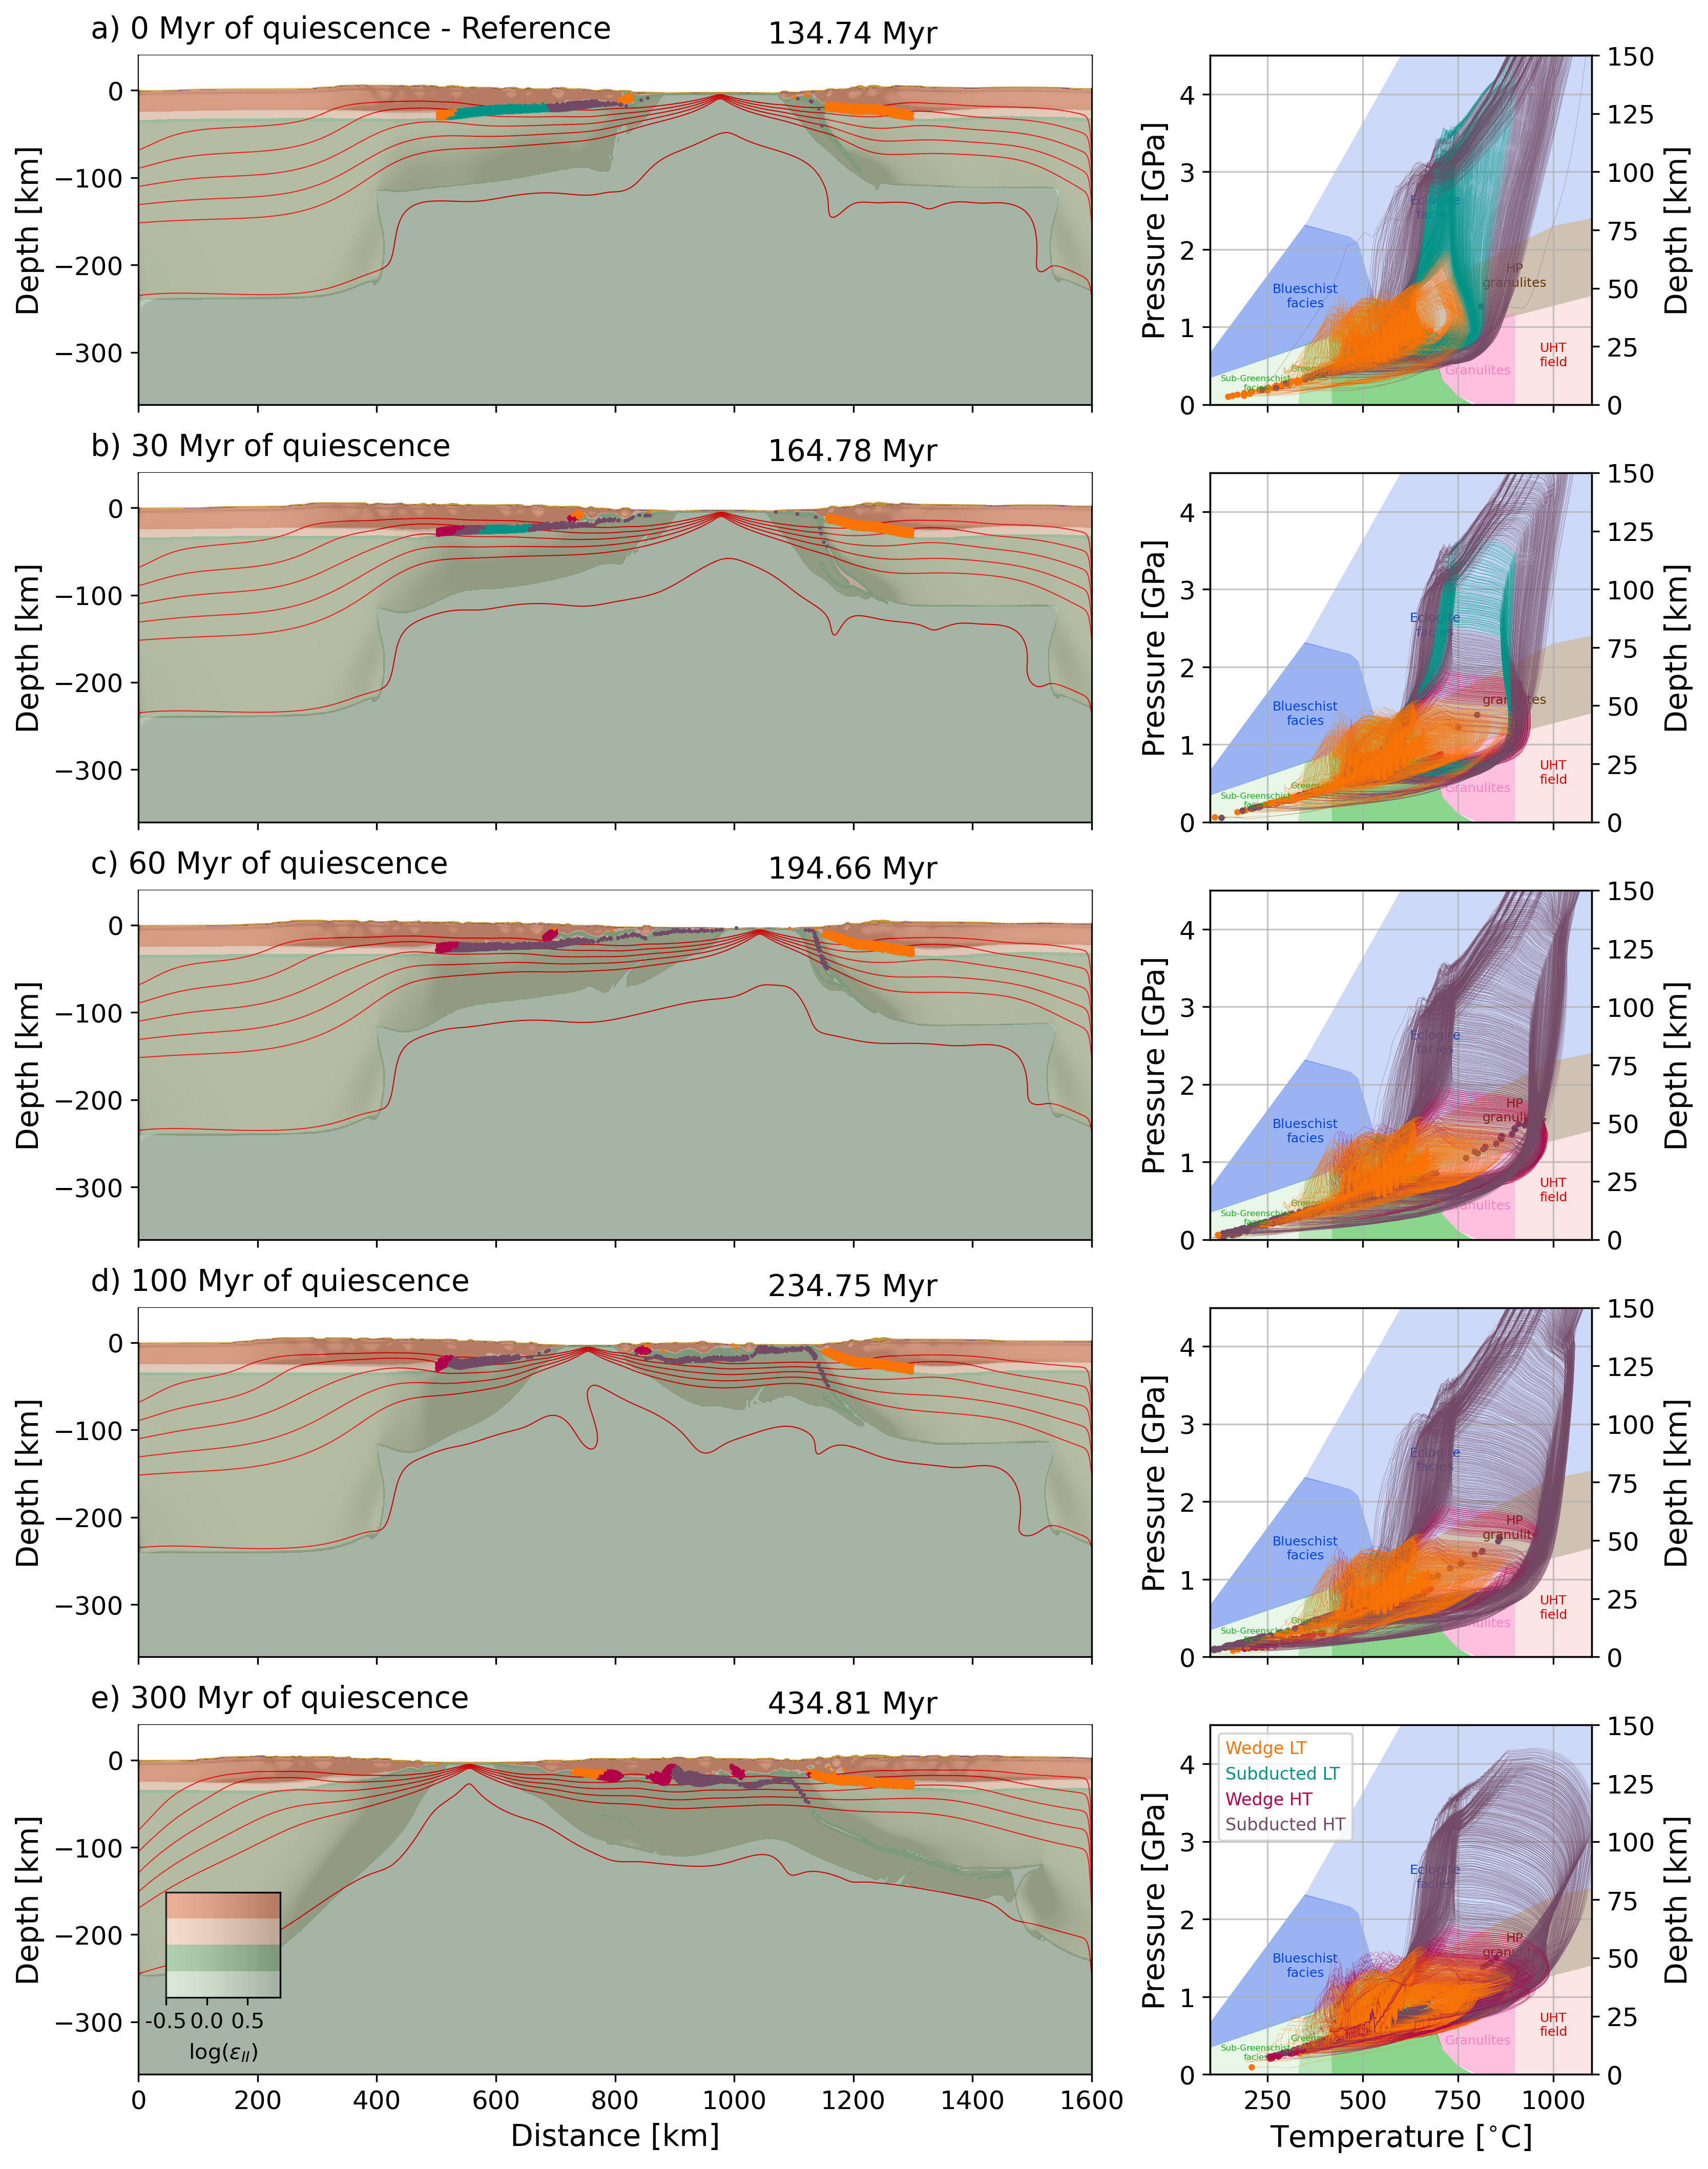

In [6]:
##############################################################################################################
#Set mandyoc property to plot

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

i = 0
# zoom_uc = True
zoom_uc = False

Lcraton = 1200.0

if(prop != 'surface'): # you can customize
    xlims = [0, float(datasets[0].isel(time=i).lx) / 1.0e3]
    ylims = [-float(datasets[0].isel(time=i).lz) / 1.0e3 + 40, 40]
    # xlims = [600, 1600]
    # ylims = [-130, 40]
    # plot steps
    plot_particles = False
        # print(xlims, ylims)
else: #for surface plot
    xmin = 0 #+ 200
    xmax = float(datasets[0].isel(time=i).lx) / 1.0E3 #- 200
    xlims = [xmin, xmax]
    ylims = [-1.5, 1.5]


# plt.close('all')
plot_lower_crust_particles = True

fig, axs = plt.subplots(5, 2, figsize=(11, 14), constrained_layout=True, dpi=300, gridspec_kw={'width_ratios': [1, 0.4]})
axs = axs.flatten()
topo_from_density = True

plot_final_step = True
# plot_final_step = False

instant_to_plot = 74

color_wedge = 'xkcd:orange' #orogenic wedge rocks 400<T<900 and P<2GPa
color_mid_T = 'xkcd:teal' #subducted crustal rocks 400<T<900 and P>2GPa
color_high_T_wedge = 'xkcd:raspberry' #orogenic wedge rocks T>=900 and P<2GPa
color_high_T_subducted = 'xkcd:dirty purple' #subducted crustal rocks T>900 and P>2GPa

for scenario, dataset, trackdataset, i in zip(scenarios, datasets, trackdatasets, range(len(datasets))):
    if(scenario == scenarios[-1]):
        plot_colorbar = True
    else:
        plot_colorbar = False

    if(plot_final_step==True):
        idx = find_nearest(dataset.time, float(dataset.time.values[-1]))
        current_time = dataset.time.values[idx]
    else:
        idx = find_nearest(dataset.time, float(instant_to_plot))
        current_time = dataset.time.values[idx]

    plot_property(dataset.isel(time=idx), prop, xlims, ylims, scenarios[0],
                fig,
                axs[i*2],
                plot_isotherms = plot_isotherms,
                topo_from_density = topo_from_density,
                plot_particles = plot_particles,
                particle_size = 0.2,
                particle_marker = ".",
                ncores = 20,
                #  step_plot = 4,
                isotherms = [500, 600, 700, 800, 900, 1300],
                isotherms_linewidth = 0.5,
                plot_colorbar=plot_colorbar,
                bbox_to_anchor=(0.04,#horizontal position respective to parent_bbox or "loc" position
                            0.19,# vertical position
                            0.12,# width
                            0.30),
                # plot_melt = plot_melt,
                # melt_method = melt_method,
                )
    
        # print('ok')
        
    plot_particles_of_a_layer_temperature_coded(axs[i*2], axs[2*i+1], idx, trackdataset, markersize=4, linewidth=0.15, line_alpha=0.6, h_air=40.0e3, plot_lower_crust_particles=plot_lower_crust_particles,
                                                color_wedge=color_wedge, #orogenic wedge rocks 400<T<900 and P<2GPa
                                                color_mid_T=color_mid_T, #subducted crustal rocks 400<T<900 and P>2GPa
                                                color_high_T_wedge=color_high_T_wedge, #orogenic wedge rocks T>=900 and P<2GPa
                                                color_high_T_subducted=color_high_T_subducted, #subducted crustal rocks T>900 and P>2GPa
                                                )

    plot_PT_fields(axs[i*2+1], vertices_UHT, x_text=x_text_UHT, y_text=y_text_UHT, label=label_UHT,
                           color=color_UHT, fsize_text=fsize_UHT, alpha=alpha_UHT)
    plot_PT_fields(axs[i*2+1], vertices_granulite_HP, x_text=x_text_granulite_HP, y_text=y_text_granulite_HP, label=label_granulite_HP,
                    color=color_granulite_HP, fsize_text=fsize_granulite_HP, alpha=alpha_granulite_HP)
    plot_PT_fields(axs[i*2+1], vertices_eclogite, x_text=x_text_eclogite, y_text=y_text_eclogite, label=label_eclogite,
                    color=color_eclogite, fsize_text=fsize_eclogite, alpha=alpha_eclogite)
    plot_PT_fields(axs[i*2+1], vertices_granulite, x_text=x_text_granulite, y_text=y_text_granulite, label=label_granulite,
                    color=color_granulite, fsize_text=fsize_granulite, alpha=alpha_granulite)
    plot_PT_fields(axs[i*2+1], vertices_anfibolite, x_text=x_text_anfibolite, y_text=y_text_anfibolite, label=label_anfibolite,
                    color=color_anfibolite, fsize_text=fsize_anfibolite, alpha=alpha_anfibolite)
    plot_PT_fields(axs[i*2+1], vertices_blueschist, x_text=x_text_blueschist, y_text=y_text_blueschist, label=label_blueschist,
                    color=color_blueschist, fsize_text=fsize_blueschist, alpha=alpha_blueschist)
    plot_PT_fields(axs[i*2+1], vertices_greenschiest, x_text=x_text_greenschiest, y_text=y_text_greenschiest, label=label_greenschiest,
                    color=color_greenschiest, fsize_text=fsize_greenschiest, alpha=alpha_greenschiest)
    plot_PT_fields(axs[i*2+1], vertices_sub_greenschiest, x_text=x_text_sub_greenschiest, y_text=y_text_sub_greenschiest, label=label_sub_greenschiest,
                    color=color_sub_greenschiest, fsize_text=fsize_sub_greenschiest, alpha=alpha_sub_greenschiest)
fsize=14
markersize = 4

titles = {
    scenarios[0].split('/')[-1]: "0 Myr of quiescence - Reference",
    scenarios[1].split('/')[-1]: "30 Myr of quiescence",
    scenarios[2].split('/')[-1]: "60 Myr of quiescence",
    scenarios[3].split('/')[-1]: "100 Myr of quiescence",
    scenarios[4].split('/')[-1]: "300 Myr of quiescence"
}

line_labels = np.asarray(list(string.ascii_lowercase)[0: len(scenarios)])
for line_label, i in zip(line_labels, range(len(line_labels))):
    axs[2*i].text(-0.05, 1.05, f"{line_label}) {titles[scenarios[i].split('/')[-1]]}", transform=axs[2*i].transAxes, fontsize=fsize, color='black')

for ax in axs:
    if(ax.get_subplotspec().is_first_col()):
        ax.set_ylabel('Depth [km]', fontsize=fsize)

        if(ax.get_subplotspec().is_last_row()):
            ax.set_xlabel('Distance [km]', fontsize=fsize)
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])

    if(ax.get_subplotspec().is_last_col()):
        ax.set_xlim([100, 1100])
        ylims = np.array([0, 4500])/1.0e3 #GPa
        ax.set_ylim(ylims)
        ax.set_ylabel('Pressure [GPa]', fontsize=fsize)

        ax.tick_params(axis='both', labelsize=fsize-2)
        ax.grid('-k', alpha=0.7)

        #creating depth axis to PTt plot
        ax1 = ax.twinx()
        ax1.set_ylim(ylims*1000/30)
        # ax1.tick_params(axis='y', labelright=False, labelleft=True, labelsize=fsize)
        ax1.set_ylabel('Depth [km]', fontsize=fsize)
        ax1.tick_params(axis='y', labelsize=fsize-2)
        # nticks = len(axs[1].get_yticks())
        # ax1.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
        # ax1.yaxis.set_label_position("left")

        #creating legend for particles

        if(ax.get_subplotspec().is_last_row()):
            ax.set_xlabel(r'Temperature [$^{\circ}$C]', fontsize=fsize)
            ax.plot([-10,-10], [-10,-10], '-', color=color_wedge, markersize=markersize, label='Wedge LT', zorder=60)
            ax.plot([-10,-10], [-10,-10], '-', color=color_mid_T, markersize=markersize, label='Subducted LT', zorder=60)
            ax.plot([-10,-10], [-10,-10], '-', color=color_high_T_wedge, markersize=markersize, label='Wedge HT', zorder=60)
            ax.plot([-10,-10], [-10,-10], '-', color=color_high_T_subducted, markersize=markersize, label='Subducted HT', zorder=60)

            ax.legend(loc='upper left', ncol=1, fontsize=8, handlelength=0, handletextpad=0, labelcolor='linecolor')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])

In [5]:
titles

{'MR_dk2.4': '0 Myr of quiescence - Reference',
 'M30_dk1': '30 Myr of quiescence',
 'M60_dk1': '60 Myr of quiescence',
 'M100_dk1.1': '300 Myr of quiescence'}